In [3]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


import xgboost as xgb


In [4]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()
    

In [5]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    
    train = average_speakers(train)
    
    return train, test


train, test = load_data()

C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


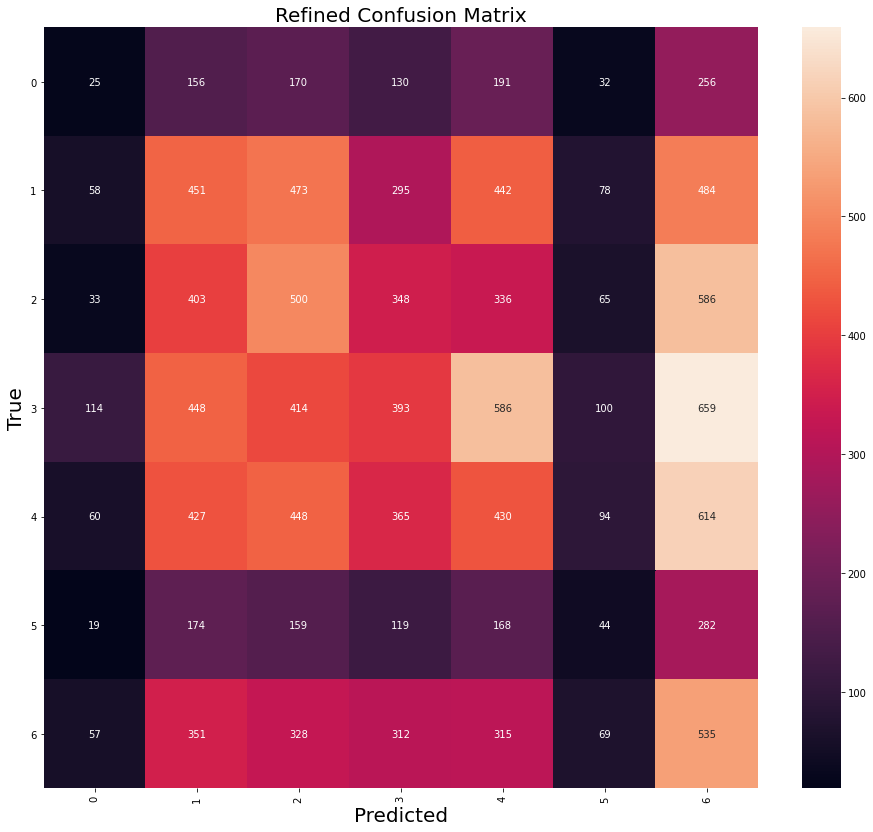

XGBoost accuracy: 0.17490438364224772
XGBoost number of mislabeled points out of a total 13596 points : 11218
                  DR1          DR2          DR3          DR4          DR5  \
precision    0.068306     0.187137     0.200642     0.200306     0.174230   
recall       0.026042     0.197720     0.220167     0.144805     0.176374   
f1-score     0.037707     0.192283     0.209952     0.168092     0.175296   
support    960.000000  2281.000000  2271.000000  2714.000000  2438.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.091286     0.156616  0.174904      0.154075      0.170098  
recall       0.045596     0.271988  0.174904      0.154670      0.174904  
f1-score     0.060815     0.198774  0.174904      0.148989      0.168053  
support    965.000000  1967.000000  0.174904  13596.000000  13596.000000  


In [6]:
def xgb_me(train, test, display_conf=True, word = None, accents=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
        
    x_boost = xgb.XGBClassifier()
    
    x_boost.fit(X_train, y_train)
    
    y_pred = x_boost.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"XGBoost accuracy: {acc}")
        print(f"XGBoost number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return x_boost, y_pred, conf_df, classification_report(y_test, y_pred), acc


x_boost, x_boost_pred, x_boost_conf, x_boost_mat, acc = xgb_me(train, test)

In [7]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test



In [8]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_train.head()

,speaker,word,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,accent,region
0,FAEM0,a,-353.348083,134.518519,-9.184594,-18.755492,-21.228213,-6.953157,-22.371318,-27.997338,-5.364247,4.490220,-6.668658,0.257785,North,North
1,FAEM0,after,-347.818909,106.672279,-45.025673,18.032808,-14.631424,-27.376530,-19.641098,-15.697500,1.943836,-9.809213,4.143702,-5.511507,North,North
2,FAEM0,all,-360.966278,126.600243,-24.294479,-38.255478,-69.742477,-17.396694,20.758194,-35.852512,-4.462066,-16.974424,-4.133724,-1.038600,North,North
3,FAEM0,always,-317.568298,108.726196,-11.648054,-37.803394,-61.665752,-5.345030,0.926592,-29.949045,-6.787814,-16.826244,4.379314,-9.666162,North,North
4,FAEM0,an,-392.887268,107.063339,-18.115166,39.589870,-27.925322,-45.015396,-20.218822,-21.476480,0.229233,-33.994270,3.304021,-11.966344,North,North


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


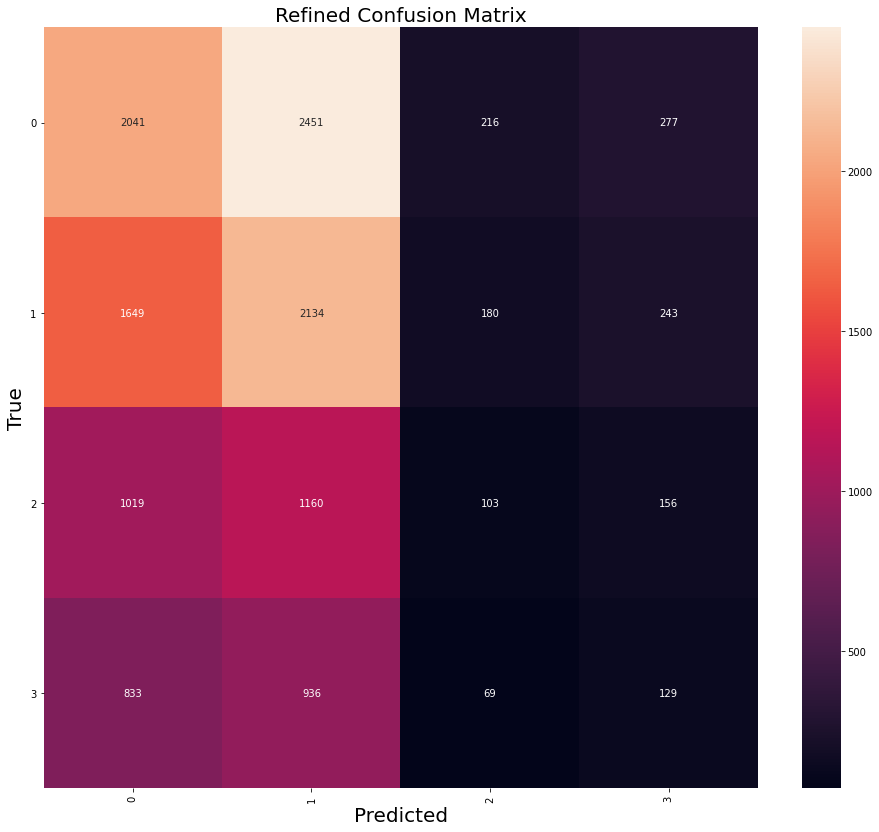

XGBoost accuracy: 0.3241394527802295
XGBoost number of mislabeled points out of a total 13596 points : 9189
                   Mid        North        South         West  accuracy  \
precision     0.368279     0.319413     0.181338     0.160248  0.324139   
recall        0.409428     0.507370     0.042248     0.065582  0.324139   
f1-score      0.387765     0.392027     0.068530     0.093074  0.324139   
support    4985.000000  4206.000000  2438.000000  1967.000000  0.324139   

              macro avg  weighted avg  
precision      0.257320      0.289543  
recall         0.256157      0.324139  
f1-score       0.235349      0.289205  
support    13596.000000  13596.000000  


In [9]:
x_boost, x_boost_pred, x_boost_conf, x_boost_mat, acc = xgb_me(condensed_train, condensed_test)

In [10]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'Mid',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    27407
Mid      5821
Name: accent, dtype: int64

C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


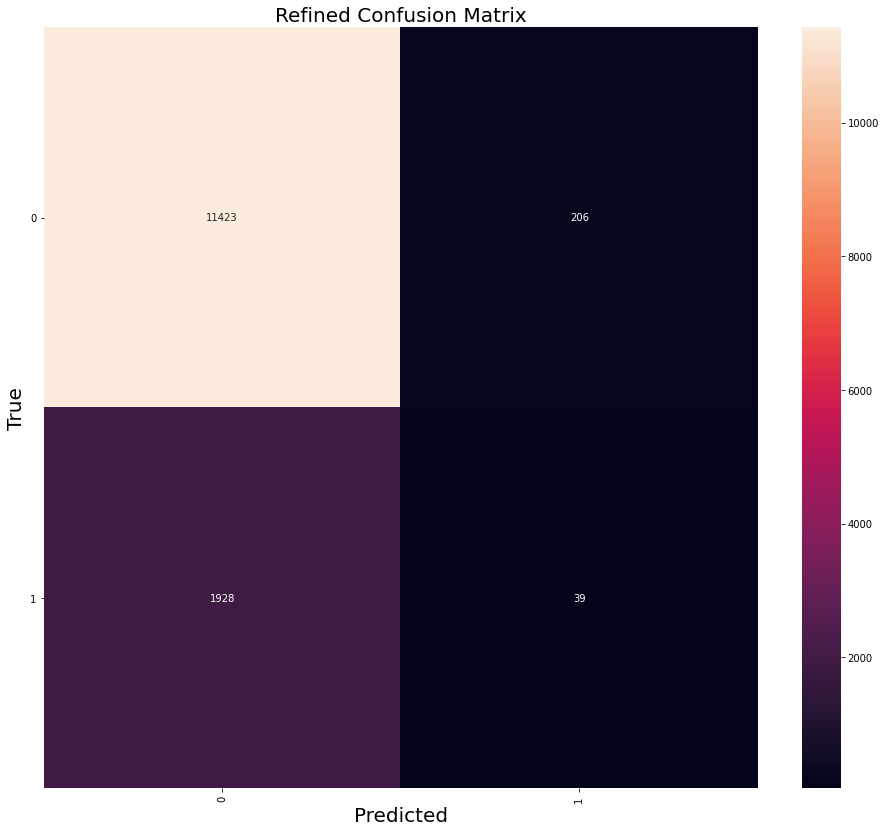

XGBoost accuracy: 0.843042071197411
XGBoost number of mislabeled points out of a total 13596 points : 2134
                   East          Mid  accuracy     macro avg  weighted avg
precision      0.855591     0.159184  0.843042      0.507388      0.754839
recall         0.982286     0.019827  0.843042      0.501056      0.843042
f1-score       0.914572     0.035262  0.843042      0.474917      0.787358
support    11629.000000  1967.000000  0.843042  13596.000000  13596.000000


In [11]:
x_boost, x_boost_pred, x_boost_conf, x_boost_mat, acc = xgb_me(condensed_train_two_regions, condensed_tes_two_regions)